
=== Lab 1.1: Toy tuning functions ===


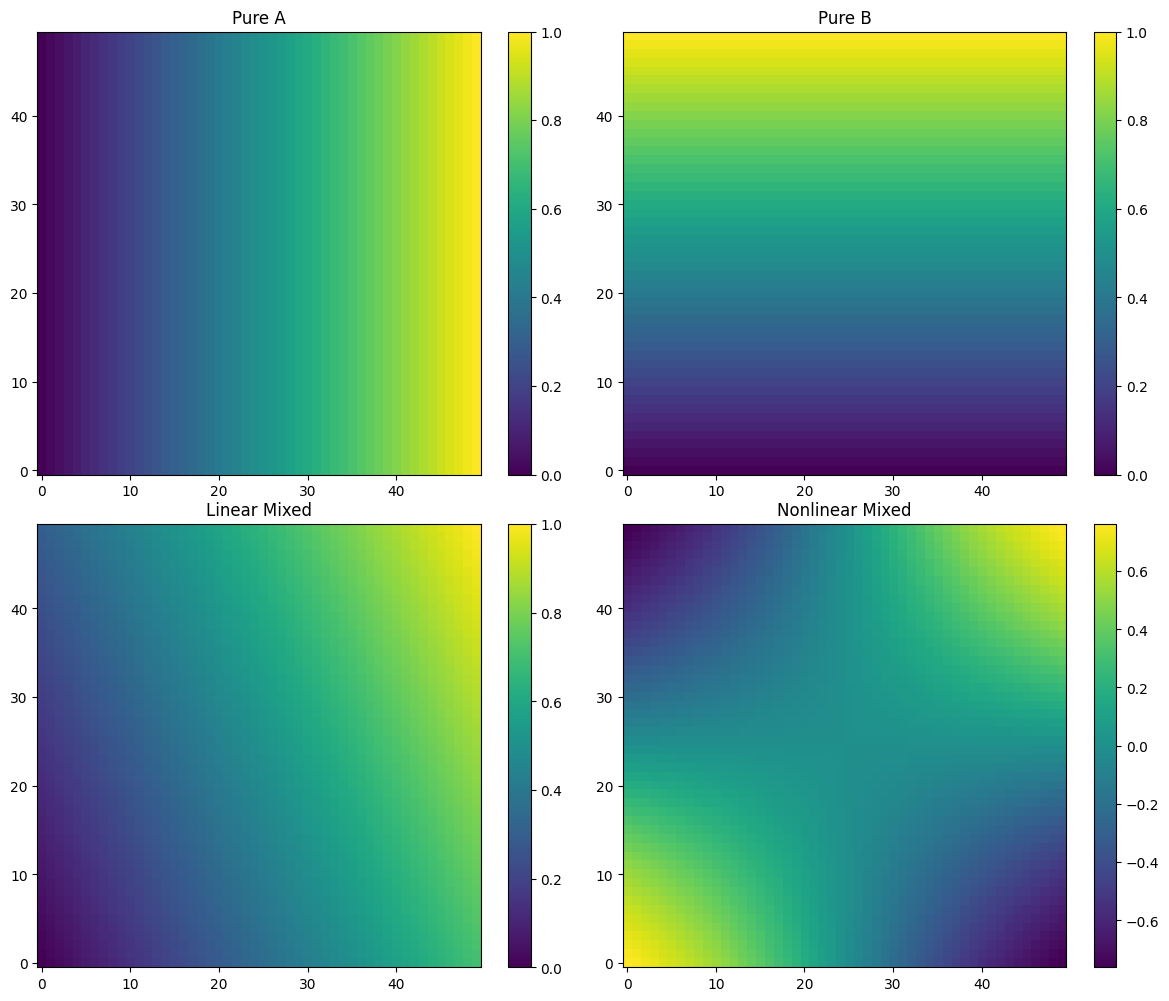


=== Lab 1.2: Dimensionality ===
Effective dimensionality (90% var): 20


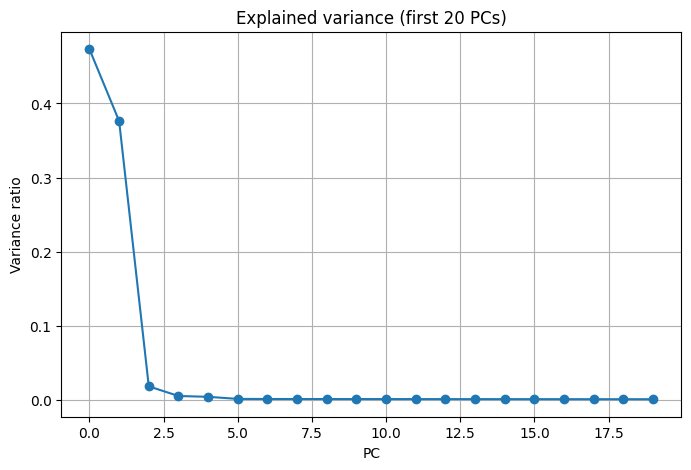


=== Lab 1.3: XOR readout ===
Accuracy from raw inputs: 0.508
Accuracy from mixed-selectivity features: 0.94


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



# ============================================================
#  Lab 1.1 — Toy tuning functions
# ============================================================

def generate_grid(n=50):
    a = np.linspace(0, 1, n)
    b = np.linspace(0, 1, n)
    A, B = np.meshgrid(a, b)
    return A, B

def toy_neurons(A, B):
    r1 = A                          # pure A
    r2 = B                          # pure B
    r3 = 0.7*A + 0.3*B              # linear mixed
    r4 = np.tanh(4*(A-0.5)*(B-0.5)) # nonlinear mixed
    return [r1, r2, r3, r4]

def plot_toy_neurons(neurons):
    titles = ["Pure A", "Pure B", "Linear Mixed", "Nonlinear Mixed"]
    plt.figure(figsize=(12, 10))
    for i, r in enumerate(neurons):
        plt.subplot(2,2,i+1)
        plt.imshow(r, origin='lower', cmap='viridis')
        plt.colorbar()
        plt.title(titles[i])
    plt.tight_layout()
    plt.show()

# ============================================================
#  Lab 1.2 — Dimensionality of population responses
# ============================================================

def generate_population_data(M=500, N=200):
    """
    M = number of samples (stimuli)
    N = number of neurons
    Half pure, half nonlinear-mixed
    """
    A = np.random.rand(M)
    B = np.random.rand(M)

    neurons = []
    for i in range(N):
        if i < N//2:
            # pure
            if np.random.rand() < 0.5:
                r = A + 0.1*np.random.randn(M)
            else:
                r = B + 0.1*np.random.randn(M)
        else:
            # nonlinear mixed
            wA = np.random.randn()
            wB = np.random.randn()
            wAB = np.random.randn()
            r = np.tanh(wA*A + wB*B + wAB*(A*B)) + 0.1*np.random.randn(M)
        neurons.append(r)
    R = np.vstack(neurons).T  # shape M × N
    return R

def compute_dimensionality(R):
    pca = PCA()
    pca.fit(R)
    ev = pca.explained_variance_ratio_
    dim90 = np.where(np.cumsum(ev) >= 0.90)[0][0] + 1
    return ev, dim90

def plot_pca(ev):
    plt.figure(figsize=(8,5))
    plt.plot(ev[:20], 'o-')
    plt.title("Explained variance (first 20 PCs)")
    plt.xlabel("PC")
    plt.ylabel("Variance ratio")
    plt.grid(True)
    plt.show()

# ============================================================
#  Lab 1.3 — Linear readout power (XOR task)
# ============================================================

def generate_xor_data(M=500):
    A = np.random.rand(M)
    B = np.random.rand(M)

    # XOR label
    y = ((A > 0.5) ^ (B > 0.5)).astype(int)

    X_raw = np.vstack([A, B]).T

    # Nonlinear mixed representation
    W = np.random.randn(200, 2)
    H = np.tanh(X_raw @ W.T)

    return X_raw, H, y

def train_and_test(X, y):
    clf = LogisticRegression()
    clf.fit(X, y)
    yhat = clf.predict(X)
    return accuracy_score(y, yhat)

# ============================================================
#  Main runner
# ============================================================

if __name__ == "__main__":

    print("\n=== Lab 1.1: Toy tuning functions ===")
    A, B = generate_grid()
    neurons = toy_neurons(A, B)
    plot_toy_neurons(neurons)

    print("\n=== Lab 1.2: Dimensionality ===")
    R = generate_population_data()
    ev, dim90 = compute_dimensionality(R)
    print("Effective dimensionality (90% var):", dim90)
    plot_pca(ev)

    print("\n=== Lab 1.3: XOR readout ===")
    X_raw, H, y = generate_xor_data()

    acc_raw = train_and_test(X_raw, y)
    acc_mixed = train_and_test(H, y)

    print("Accuracy from raw inputs:", acc_raw)
    print("Accuracy from mixed-selectivity features:", acc_mixed)


Logistic accuracy on PCs: 0.951


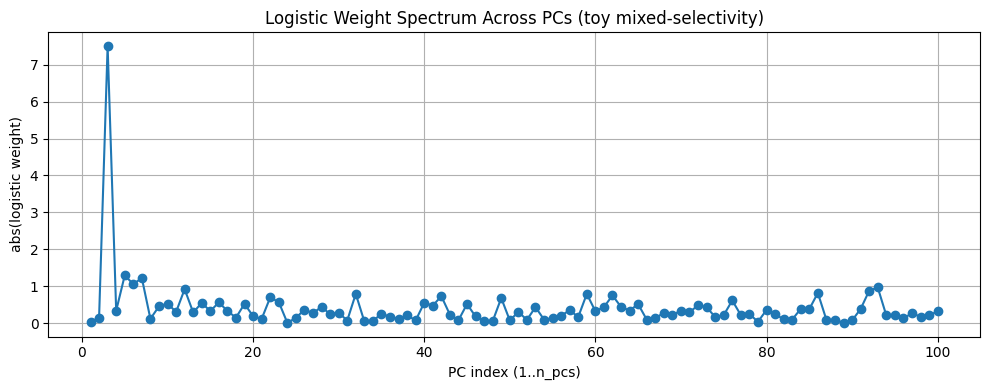

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ---------------------------------------------------------
# Generate mixed-selectivity population + labels
# ---------------------------------------------------------

def generate_population_with_labels(M=500, N=200):
    """
    M stimuli, N neurons.
    Underlying true variables: A, B in [0,1].
    Label: XOR(A>0.5, B>0.5).
    Neurons: half pure, half nonlinear mixed.
    """
    A = np.random.rand(M)
    B = np.random.rand(M)

    # XOR label
    y = ((A > 0.5) ^ (B > 0.5)).astype(int)

    neurons = []
    for i in range(N):
        if i < N//2:
            # pure A or pure B with noise
            if np.random.rand() < 0.5:
                r = A + 0.1*np.random.randn(M)
            else:
                r = B + 0.1*np.random.randn(M)
        else:
            # nonlinear mixed: random weights and interaction
            wA = np.random.randn()
            wB = np.random.randn()
            wAB = np.random.randn()
            r = np.tanh(wA*A + wB*B + wAB*(A*B)) + 0.1*np.random.randn(M)
        neurons.append(r)

    R = np.vstack(neurons).T   # M x N
    return R, y

# ---------------------------------------------------------
# PCA + logistic regression on PCs + weight spectrum
# ---------------------------------------------------------

def pca_and_logistic_spectrum(R, y, n_pcs=100):
    """
    R: M x N response matrix
    y: labels (0/1)
    n_pcs: how many PCs to use in classifier
    """
    # PCA
    pca = PCA(n_components=n_pcs)
    Z = pca.fit_transform(R)  # M x n_pcs

    # logistic regression on PC scores
    clf = LogisticRegression(max_iter=2000)
    clf.fit(Z, y)
    yhat = clf.predict(Z)
    acc = accuracy_score(y, yhat)
    print(f"Logistic accuracy on PCs: {acc:.3f}")

    # Weight spectrum
    weights = clf.coef_.ravel()
    abs_w = np.abs(weights)

    plt.figure(figsize=(10,4))
    plt.plot(np.arange(1, n_pcs+1), abs_w, marker='o')
    plt.xlabel("PC index (1..n_pcs)")
    plt.ylabel("abs(logistic weight)")
    plt.title("Logistic Weight Spectrum Across PCs (toy mixed-selectivity)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pca, clf

# ---------------------------------------------------------
# Run the whole thing
# ---------------------------------------------------------

if __name__ == "__main__":
    R, y = generate_population_with_labels(M=800, N=300)
    pca, clf = pca_and_logistic_spectrum(R, y, n_pcs=100)


Semantic latent dims: [8 7 0 3]
Semantic weights: [ 0.24470497  1.063226   -0.17661581  1.23898266]
Logistic accuracy on PCs: 0.957


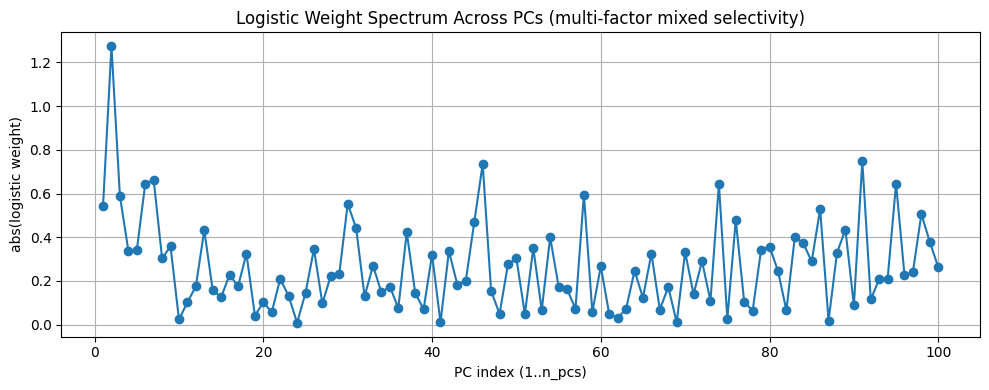

In [ ]:
#https://chatgpt.com/g/g-p-676c80353b988191819d6d02aca806d6-msc-thesis/c/693028c6-bc04-8330-848f-8f78dfc3a3cb


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ---------------------------------------------------------
# 1. Generate latent factors and labels
# ---------------------------------------------------------

def generate_latents_and_labels(M=800, d_latent=10, n_sem_factors=4, noise_std=0.3):
    """
    M: number of stimuli
    d_latent: number of latent visual factors
    n_sem_factors: how many latent dims contribute to the label
    """
    # latent factors ~ N(0,1)
    Z = np.random.randn(M, d_latent)

    # choose some latent dims that define the semantic boundary
    idx = np.arange(d_latent)
    np.random.shuffle(idx)
    sem_idx = idx[:n_sem_factors]

    # semantic weights for those factors
    w_sem = np.zeros(d_latent)
    w_sem[sem_idx] = np.random.randn(n_sem_factors)

    # linear semantic score + noise
    s = Z @ w_sem + noise_std * np.random.randn(M)

    # label: 1 if score > 0, else 0
    y = (s > 0).astype(int)

    return Z, y, sem_idx, w_sem

# ---------------------------------------------------------
# 2. Mixed-selectivity neural population
# ---------------------------------------------------------

def generate_mixed_population(Z, N_neurons=300):
    """
    Z: M x d_latent, latent factors per stimulus
    Returns: R (M x N_neurons) population responses
    """
    M, d_latent = Z.shape
    neurons = []

    for i in range(N_neurons):
        # random linear weights
        w = np.random.randn(d_latent)

        # optional interaction term: pick two random latent dims
        i1, i2 = np.random.choice(d_latent, size=2, replace=False)
        w_int = np.random.randn()

        lin = Z @ w + w_int * (Z[:, i1] * Z[:, i2])

        # nonlinear firing (tanh mixed selectivity)
        r = np.tanh(lin) + 0.05 * np.random.randn(M)

        neurons.append(r)

    R = np.vstack(neurons).T   # M x N
    return R

# ---------------------------------------------------------
# 3. PCA + logistic regression on PCs + spectrum
# ---------------------------------------------------------

def pca_and_logistic_spectrum(R, y, n_pcs=100):
    pca = PCA(n_components=n_pcs)
    Zp = pca.fit_transform(R)

    clf = LogisticRegression(max_iter=3000)
    clf.fit(Zp, y)
    yhat = clf.predict(Zp)
    acc = accuracy_score(y, yhat)
    print(f"Logistic accuracy on PCs: {acc:.3f}")

    weights = clf.coef_.ravel()
    abs_w = np.abs(weights)

    plt.figure(figsize=(10,4))
    plt.plot(np.arange(1, n_pcs+1), abs_w, marker='o')
    plt.xlabel("PC index (1..n_pcs)")
    plt.ylabel("abs(logistic weight)")
    plt.title("Logistic Weight Spectrum Across PCs (multi-factor mixed selectivity)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pca, clf, abs_w

# ---------------------------------------------------------
# 4. Run
# ---------------------------------------------------------

if __name__ == "__main__":
    # Step 1: latent factors + labels
    Z_latent, y, sem_idx, w_sem = generate_latents_and_labels(
        M=1000, d_latent=10, n_sem_factors=4, noise_std=0.4
    )
    print("Semantic latent dims:", sem_idx)
    print("Semantic weights:", w_sem[sem_idx])

    # Step 2: neural population
    R = generate_mixed_population(Z_latent, N_neurons=400)

    # Step 3: PCA + logistic spectrum
    pca, clf, abs_w = pca_and_logistic_spectrum(R, y, n_pcs=100)
